In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/breast-cancer/tensorflow2/default/1/best_model (10).keras
/kaggle/input/ddsm-mammography/cv10_labels.npy
/kaggle/input/ddsm-mammography/test10_labels.npy
/kaggle/input/ddsm-mammography/training10_1/training10_1.tfrecords
/kaggle/input/ddsm-mammography/cv10_data/cv10_data.npy
/kaggle/input/ddsm-mammography/test10_data/test10_data.npy
/kaggle/input/ddsm-mammography/training10_3/training10_3.tfrecords
/kaggle/input/ddsm-mammography/training10_2/training10_2.tfrecords
/kaggle/input/ddsm-mammography/training10_0/training10_0.tfrecords
/kaggle/input/ddsm-mammography/training10_4/training10_4.tfrecords


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import keras_cv
import math

2025-06-21 03:35:37.984734: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750476938.166270      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750476938.225268      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
BATCH_SIZE = 32
EPOCHS = 100
IMG_SIZE = 299
CHANNELS = 1

def parse_tfrecord(example_proto):
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label_normal': tf.io.FixedLenFeature([], tf.int64),
        'label': tf.io.FixedLenFeature([], tf.int64)
    }

    parsed_features = tf.io.parse_single_example(example_proto, feature_description)

    image = tf.io.decode_raw(parsed_features['image'], tf.uint8)
    image = tf.reshape(image, [IMG_SIZE, IMG_SIZE, 1])
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = tf.cast(image, tf.float32) / 255.0

    label = parsed_features['label']

    label = tf.one_hot(label, 5, dtype=tf.float32)

    return image, label

In [4]:
def create_dataset(tfrecord_files, batch_size=BATCH_SIZE):
    """Create dataset from TFRecord files"""
    dataset = tf.data.TFRecordDataset(tfrecord_files)
    dataset = dataset.map(parse_tfrecord, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(1000)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

In [5]:
def create_numpy_dataset(data_path, labels_path, batch_size=BATCH_SIZE, is_training=False):
    if isinstance(data_path, str):
        data = np.load(data_path, mmap_mode='r')
        labels = np.load(labels_path, mmap_mode='r')
    else:
        data = data_path
        labels = labels_path

    def generator():
        for i in range(len(data)):
            # Process image
            image = data[i].reshape(IMG_SIZE, IMG_SIZE, 1)
            image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
            #image = image.astype('uint8')
            image = tf.cast(image, tf.float32) / 255.0

            label_index = labels[i]
            one_hot_label = np.zeros(5, dtype=np.float32)
            one_hot_label[label_index] = 1.0

            yield image, one_hot_label

    return tf.data.Dataset.from_generator(
        generator,
        output_signature=(
            tf.TensorSpec(shape=(IMG_SIZE, IMG_SIZE, 1), dtype=tf.float32),
            tf.TensorSpec(shape=(5,), dtype=tf.float32)
        )
    ).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [6]:
import numpy as np

print("Loading training dataset...")
train_files = [f'/kaggle/input/ddsm-mammography/training10_{i}/training10_{i}.tfrecords' for i in range(5)]
train_dataset = create_dataset(train_files, BATCH_SIZE)

# Extract labels from train_dataset
train_labels_list = []

for _, labels in train_dataset:
    label_indices = np.argmax(labels.numpy(), axis=1)
    train_labels_list.extend(label_indices)

train_labels = np.array(train_labels_list)

# Function to compute class weights
def compute_class_weights(labels, class_names):
    unique, counts = np.unique(labels, return_counts=True)
    total_samples = np.sum(counts)
    num_classes = len(class_names)

    # Raw frequency-based inverse weighting
    beta = total_samples / (num_classes * counts)

    print("\nTraining Set Label Distribution and Class Weights (Beta):")
    for i, count in zip(unique, counts):
        print(f"{class_names[i]}: count={count}, beta={beta[i]:.4f}")
    
    return dict(zip(unique, beta))

# Define class names
#class_names = ['Normal', 'Benign Calc', 'Benign Mass', 'Malignant Calc', 'Malignant Mass']



class_names = ['Negative', 'Benign Calcification', 'Benign Mass',
               'Malignant Calcification', 'Malignant Mass']

# Compute and print class weights
train_class_weights = compute_class_weights(train_labels, class_names)

train_beta = np.array(list(train_class_weights.values()))
train_beta

Loading training dataset...


I0000 00:00:1750476956.937475      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0



Training Set Label Distribution and Class Weights (Beta):
Negative: count=48596, beta=0.2300
Benign Calcification: count=2103, beta=5.3148
Benign Mass: count=1911, beta=5.8488
Malignant Calcification: count=1463, beta=7.6398
Malignant Mass: count=1812, beta=6.1683


array([0.22999835, 5.3147884 , 5.84877028, 7.63978127, 6.1683223 ])

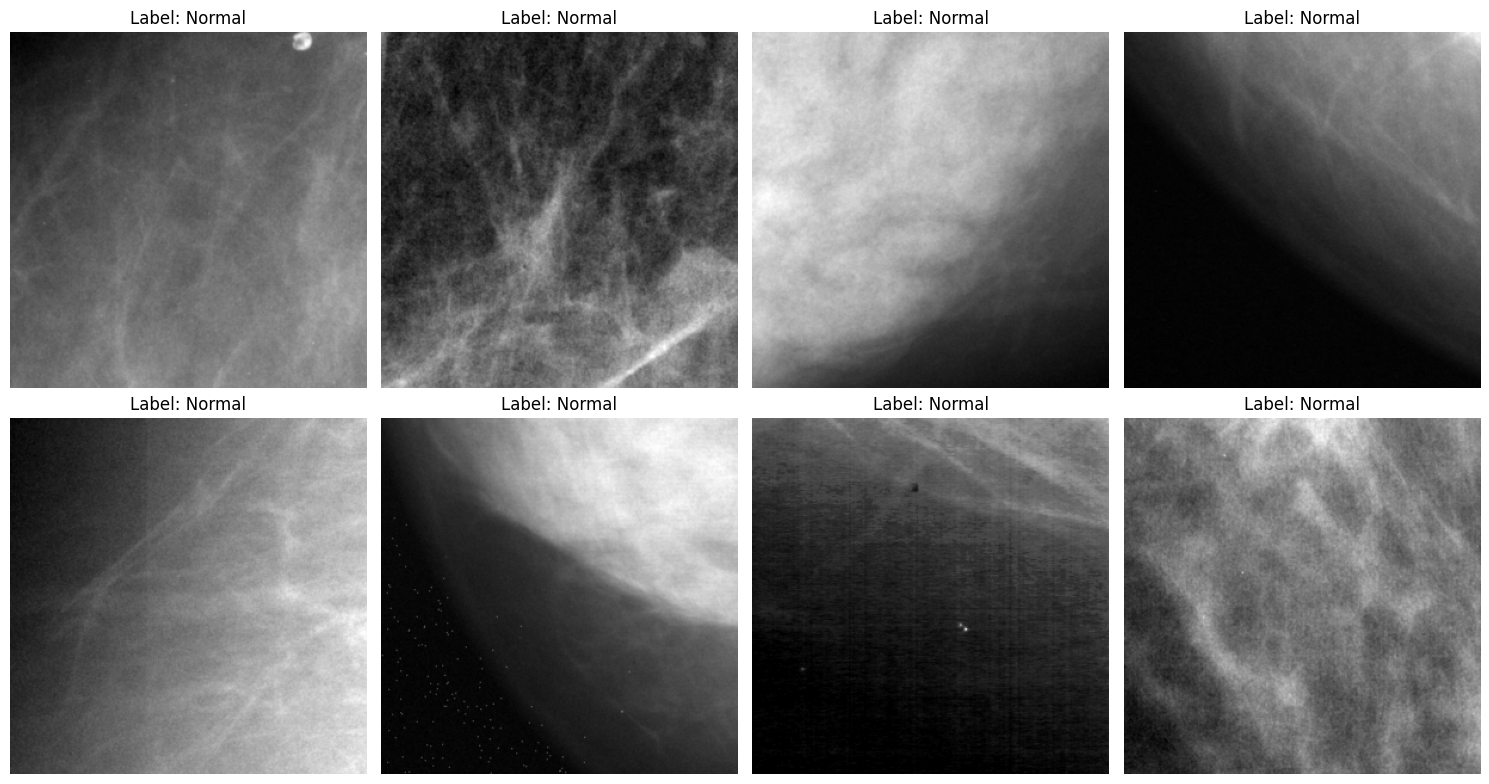

In [7]:
import matplotlib.pyplot as plt
import numpy as np

def display_batch(dataset, num_images=8):
    """
    Display images from a batch of the dataset
    """
    # Get one batch
    for images, labels in dataset.take(1):
        plt.figure(figsize=(15, 8))
        
        # Display up to num_images from the batch
        for i in range(min(num_images, len(images))):
            plt.subplot(2, 4, i + 1)
            
            # Convert tensor to numpy and display
            img = images[i].numpy()
            label = np.argmax(labels[i].numpy())
            
            # Map label index to class name
            label_names = ['Normal', 'Abnormal Type 1', 'Abnormal Type 2', 
                         'Abnormal Type 3', 'Abnormal Type 4']
            title = f'Label: {label_names[label]}'
            
            plt.imshow(img, cmap='gray')
            plt.title(title)
            plt.axis('off')
            
        plt.tight_layout()
        plt.show()

# Display images from your dataset
display_batch(train_dataset)

# To display multiple batches, you can use:
#for batch in train_dataset.take(10):
#    display_batch(train_dataset)

In [8]:
#Validation et Test Data needs to be combined to mix Masses and Calcifications
print("Loading and combining validation/test data...")
test_data = np.load('/kaggle/input/ddsm-mammography/test10_data/test10_data.npy', mmap_mode='r')
test_labels = np.load('/kaggle/input/ddsm-mammography/test10_labels.npy', mmap_mode='r')

cv_data = np.load('/kaggle/input/ddsm-mammography/cv10_data/cv10_data.npy', mmap_mode='r')
cv_labels = np.load('/kaggle/input/ddsm-mammography/cv10_labels.npy', mmap_mode='r')

combined_data = np.concatenate([test_data, cv_data])
combined_labels = np.concatenate([test_labels, cv_labels])

#Shuffling the Data
#np.random.shuffle(combined_data)
indices = np.random.permutation(len(combined_data))
combined_data = combined_data[indices]
combined_labels = combined_labels[indices]

Loading and combining validation/test data...


In [9]:
val_split = int(len(combined_data) * 0.65)
val_dataset = create_numpy_dataset(
    combined_data[:val_split],
    combined_labels[:val_split],
    BATCH_SIZE,
    is_training=False
)




test_dataset = create_numpy_dataset(
    combined_data[val_split:],
    combined_labels[val_split:],
    BATCH_SIZE,
    is_training=False
)



# Extract validation labels for use in evaluation/prediction
val_labels = combined_labels[val_split:]  # ✅ This is what you use in model.predict comparison





class_names = ['Negative', 'Benign Calcification', 'Benign Mass',
               'Malignant Calcification', 'Malignant Mass']

print(train_dataset.take(1))
print(val_dataset.take(2))

def print_label_distribution(labels):
    unique, counts = np.unique(labels, return_counts=True)
    dist = dict(zip(unique, counts))
    print("\nLabel distribution:")
    for label_idx, count in dist.items():
        print(f"{class_names[label_idx]}: {count} samples ({count/len(labels)*100:.2f}%)")

print("\nValidation set:")
print_label_distribution(combined_labels[:val_split])
print("\nTest set:")
print_label_distribution(combined_labels[val_split:])

<_TakeDataset element_spec=(TensorSpec(shape=(None, 299, 299, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>
<_TakeDataset element_spec=(TensorSpec(shape=(None, 299, 299, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>

Validation set:

Label distribution:
Negative: 8658 samples (86.70%)
Benign Calcification: 358 samples (3.59%)
Benign Mass: 442 samples (4.43%)
Malignant Calcification: 243 samples (2.43%)
Malignant Mass: 285 samples (2.85%)

Test set:

Label distribution:
Negative: 4702 samples (87.43%)
Benign Calcification: 200 samples (3.72%)
Benign Mass: 200 samples (3.72%)
Malignant Calcification: 126 samples (2.34%)
Malignant Mass: 150 samples (2.79%)


As we can see, the data is highly unbalanced, we need consider that during training by adjusting the weights

In [10]:
import numpy as np

print("Loading training dataset...")
train_files = [f'/kaggle/input/ddsm-mammography/training10_{i}/training10_{i}.tfrecords' for i in range(5)]
train_dataset = create_dataset(train_files, BATCH_SIZE)

# Extract labels from train_dataset
train_labels_list = []

for _, labels in train_dataset:
    label_indices = np.argmax(labels.numpy(), axis=1)
    train_labels_list.extend(label_indices)

train_labels = np.array(train_labels_list)

# Function to compute class weights
def compute_class_weights(labels, class_names):
    unique, counts = np.unique(labels, return_counts=True)
    total_samples = np.sum(counts)
    num_classes = len(class_names)

    # Raw frequency-based inverse weighting
    beta = total_samples / (num_classes * counts)

    print("\nTraining Set Label Distribution and Class Weights (Beta):")
    for i, count in zip(unique, counts):
        print(f"{class_names[i]}: count={count}, beta={beta[i]:.4f}")
    
    return dict(zip(unique, beta))

# Define class names
#class_names = ['Normal', 'Benign Calc', 'Benign Mass', 'Malignant Calc', 'Malignant Mass']



class_names = ['Negative', 'Benign Calcification', 'Benign Mass',
               'Malignant Calcification', 'Malignant Mass']

# Compute and print class weights
train_class_weights = compute_class_weights(train_labels, class_names)

train_beta = np.array(list(train_class_weights.values()))
train_beta

Loading training dataset...

Training Set Label Distribution and Class Weights (Beta):
Negative: count=48596, beta=0.2300
Benign Calcification: count=2103, beta=5.3148
Benign Mass: count=1911, beta=5.8488
Malignant Calcification: count=1463, beta=7.6398
Malignant Mass: count=1812, beta=6.1683


array([0.22999835, 5.3147884 , 5.84877028, 7.63978127, 6.1683223 ])

In [11]:
import tensorflow as tf

class AdaptiveCategoricalFocalLoss(tf.keras.losses.Loss):
    def __init__(self, gamma=2, epsilon=1e-7, beta=None, name="adaptive_categorical_focal_loss", update_epochs=5):
        """
        Args:
            gamma (float): Focusing parameter.
            epsilon (float): Small value to avoid numerical issues.
            beta (None or tensor-like): If provided, beta is treated as a static parameter.
                                         For multi-class, beta can be a vector of shape [num_classes].
            update_epochs (int): How often to update hyperparameters (if using dynamic ones).
        """
        super(AdaptiveCategoricalFocalLoss, self).__init__(name=name)
        self.gamma = tf.Variable(gamma, trainable=False, dtype=tf.float32)
        self.epsilon = epsilon
        self.lambda_val = tf.Variable(0.7, trainable=False, dtype=tf.float32)  # Initial value for lambda

        if beta is None:
            # Default beta is a scalar which will be broadcasted; for multi-class you can supply a vector.
            self.beta = tf.Variable(0.5, trainable=False, dtype=tf.float32)
            self.dynamic_beta = True  # Will update beta dynamically later (if desired)
        else:
            # If beta is provided, ensure it is a tensor with appropriate shape (e.g., [num_classes]).
            self.beta = tf.Variable(tf.convert_to_tensor(beta, dtype=tf.float32), trainable=False)
            self.dynamic_beta = False

        self.update_epochs = update_epochs

    def update_lambda_beta_gamma(self, y_true, y_pred):
        """
        Dynamically updates lambda and gamma based on validation metrics.
        Expects:
            y_true: one-hot encoded labels with shape [batch_size, num_classes].
            y_pred: softmax output probabilities with shape [batch_size, num_classes].
        """
        # Ensure tensors are float32.
        y_true = tf.cast(y_true, dtype=tf.float32)
        y_pred = tf.cast(y_pred, dtype=tf.float32)

        
        
        # Determine the number of classes.
        num_classes = 5

        
        
        # Compute the confusion matrix.
        conf_matrix = tf.math.confusion_matrix(
            y_true, y_pred, num_classes=num_classes, dtype=tf.float32
        )
        
        # Extract per-class confusion matrix components.
        tp = tf.linalg.diag_part(conf_matrix)
        fp = tf.reduce_sum(conf_matrix, axis=0) - tp
        fn = tf.reduce_sum(conf_matrix, axis=1) - tp
        tn = tf.reduce_sum(conf_matrix) - (tp + fp + fn)
        
        # Compute per-class sensitivity and specificity.
        sensitivity = tp / (tp + fn + self.epsilon)
        specificity = tn / (tn + fp + self.epsilon)
        
        # Average the metrics across classes.
        mean_sensitivity = tf.reduce_mean(sensitivity)
        mean_specificity = tf.reduce_mean(specificity)
        
        # Define the smoothing factor (EMA weight).
        alpha = 0.8
        
        # Update lambda using an Exponential Moving Average (EMA).
        new_lambda = mean_specificity / (mean_specificity + mean_sensitivity + self.epsilon)
        self.lambda_val.assign(alpha * self.lambda_val + (1 - alpha) * new_lambda)
        self.lambda_val.assign(tf.clip_by_value(self.lambda_val, 0.1, 0.9))
        
        # Calculate overall accuracy and misclassification rate.
        overall_accuracy = tf.reduce_mean(tf.cast(tf.equal(y_true, y_pred), tf.float32))
        misclassification_rate = 1 - overall_accuracy
        
        # Update gamma using EMA.
        self.gamma.assign(alpha * self.gamma + (1 - alpha) * (2 + misclassification_rate))
        
        # Debug output.
        print(f"Updated Lambda: {self.lambda_val.numpy():.4f}")
        if self.dynamic_beta:
            print(f"Updated Beta (dynamic): {self.beta.numpy()}")
        else:
            print(f"Beta (static): {self.beta.numpy()}")
        print(f"Updated Gamma: {self.gamma.numpy():.4f}")

    def call(self, y_true, y_pred):
        """
        Compute the Adaptive Categorical Focal Loss.
        """
        # Clip predictions to avoid log(0).
        y_pred = tf.clip_by_value(y_pred, self.epsilon, 1 - self.epsilon)
        
        # Standard categorical cross-entropy (BCE term).
        bce = -tf.reduce_sum(y_true * tf.math.log(y_pred), axis=-1)
        
        # Reshape beta for broadcasting.
        beta_broadcast = tf.reshape(self.beta, [1, -1])
        focal = -tf.reduce_sum(
            beta_broadcast * (1 - y_pred) ** self.gamma * y_true * tf.math.log(y_pred),
            axis=-1
        )
        
        # Combine both loss terms using lambda as a weight.
        acfl = self.lambda_val * bce + (1 - self.lambda_val) * focal
        return tf.reduce_mean(acfl)


In [21]:
import tensorflow as tf
from tensorflow.keras import layers, models

def dense_layer(x, growth_rate, name, dropout_rate=0.0):
    x1 = layers.BatchNormalization(name=name + "_bn1")(x)
    x1 = layers.Activation("relu", name=name + "_relu1")(x1)
    x1 = layers.Conv2D(4 * growth_rate, kernel_size=1, use_bias=False, name=name + "_conv1")(x1)

    x1 = layers.BatchNormalization(name=name + "_bn2")(x1)
    x1 = layers.Activation("relu", name=name + "_relu2")(x1)
    x1 = layers.Conv2D(growth_rate, kernel_size=3, padding="same", use_bias=False, name=name + "_conv2")(x1)

    if dropout_rate:
        x1 = layers.Dropout(dropout_rate, name=name + "_dropout")(x1)

    return layers.Concatenate(name=name + "_concat")([x, x1])

def dense_block(x, num_layers, growth_rate, block_idx, dropout_rate=0.0):
    for i in range(num_layers):
        x = dense_layer(x, growth_rate, name=f"conv{block_idx}_block{i+1}", dropout_rate=dropout_rate)
    return x

def transition_layer(x, name, compression=0.5):
    out_channels = int(tf.keras.backend.int_shape(x)[-1] * compression)
    x = layers.BatchNormalization(name=name + "_bn")(x)
    x = layers.Activation("relu", name=name + "_relu")(x)
    x = layers.Conv2D(out_channels, kernel_size=1, use_bias=False, name=name + "_conv")(x)
    x = layers.AveragePooling2D(pool_size=2, strides=2, name=name + "_pool")(x)
    return x

def build_custom_densenet169(input_shape=(299, 299, 1), num_classes=5, growth_rate=32, dropout_rate=0.0):
    inputs = tf.keras.Input(shape=input_shape, name="input")

    # Initial Conv and Pooling
    x = layers.Conv2D(64, kernel_size=7, strides=2, padding="same", use_bias=False, name="conv1_conv")(inputs)
    x = layers.BatchNormalization(name="conv1_bn")(x)
    x = layers.Activation("relu", name="conv1_relu")(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding="same", name="pool1")(x)

    # Dense Blocks + Transitions
    block_config = [6, 12, 32, 32]  # DenseNet-169
    for i, num_layers in enumerate(block_config):
        x = dense_block(x, num_layers=num_layers, growth_rate=growth_rate, block_idx=i + 1, dropout_rate=dropout_rate)
        if i != len(block_config) - 1:
            x = transition_layer(x, name=f"pool{i + 2}")

    x = layers.BatchNormalization(name="bn")(x)
    x = layers.Activation("relu", name="relu")(x)
    x = layers.GlobalAveragePooling2D(name="avg_pool")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="predictions")(x)

    model = models.Model(inputs=inputs, outputs=outputs, name="CustomDenseNet169")
    return model


In [13]:
loss_fn = AdaptiveCategoricalFocalLoss(beta=train_beta)

In [16]:
 

def compile_and_prepare_model(model):
    # Learning rate schedule
    initial_learning_rate = 5e-4
    decay_steps = 1000
    decay_rate = 0.9
    
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate,
        decay_steps=decay_steps,
        decay_rate=decay_rate,
        staircase=True
    )
    
    # Optimizer with weight decay
    optimizer = tf.keras.optimizers.AdamW(
        learning_rate=initial_learning_rate,
        weight_decay=0.01
    )
    
    # Compile model
    model.compile(
        optimizer=optimizer,
        loss= loss_fn,
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(),
            tf.keras.metrics.Recall(),
            tf.keras.metrics.AUC()
        ]
    )
    
    return model

In [22]:
model = build_custom_densenet169()
model = compile_and_prepare_model(model)

In [ ]:
model.summary()

In [18]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=7,                  # Number of epochs with no improvement after which training will be stopped
    min_delta=1e-7,              # Minimum change in the monitored quantity to be considered an improvement
    restore_best_weights=True,
)

plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,           # Factor by which the learning rate will be reduced (new_lr = lr * factor)
    patience=6,   
    min_delta=1e-7,
    cooldown=0,           # Number of epochs to wait before resuming normal operation after learning rate reduction
    verbose=1
)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1


    
)

In [ ]:
# Define total epochs
total_epochs = 70
update_epochs = 3  # Update hyperparameters every 5 epochs

# Training loop
for epoch in range(total_epochs):
    print(f"\nEpoch {epoch + 1}/{total_epochs}")

    # Train the model for one epoch
    history = model.fit(train_dataset,
    validation_data=val_dataset,
    epochs = 1,
    batch_size = BATCH_SIZE,
    
    callbacks=[early_stopping, plateau, model_checkpoint])

    # Update hyperparameters every `update_epochs`
    if (epoch + 1) % update_epochs == 0:
        print("\nUpdating hyperparameters...")
        # Get predictions for confusion matrix
        y_pred = np.argmax(model.predict(val_dataset), axis=1)
        y_true = np.concatenate([np.argmax(labels, axis=1) 
                                for _, labels in val_dataset])
        loss_fn.update_lambda_beta_gamma(y_true, y_pred)


In [ ]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    cohen_kappa_score,
    f1_score,
    recall_score,
    precision_score
)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Evaluate the model
results = model.evaluate(test_dataset)
print("\nTest Results:")
for name, value in zip(model.metrics_names, results):
    print(f"{name}: {value:.4f}")

# Get predictions and true labels
y_pred = np.argmax(model.predict(test_dataset), axis=1)
y_true = np.concatenate([np.argmax(labels, axis=1) for _, labels in test_dataset])

# Class names
class_names = ['Normal', 'Benign Calc', 'Benign Mass', 'Malignant Calc', 'Malignant Mass']

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

# Per-class Sensitivity (Recall)
sensitivity_per_class = cm.diagonal() / cm.sum(axis=1)
print("\nSensitivity (Recall) per class:")
for name, sens in zip(class_names, sensitivity_per_class):
    print(f"{name}: {sens:.4f}")

# Per-class Specificity
specificity_per_class = []
for i in range(len(cm)):
    TP = cm[i, i]
    FP = np.sum(cm[:, i]) - TP
    FN = np.sum(cm[i, :]) - TP
    TN = np.sum(cm) - (TP + FP + FN)
    specificity = TN / (TN + FP)
    specificity_per_class.append(specificity)

print("\nSpecificity per class:")
for name, spec in zip(class_names, specificity_per_class):
    print(f"{name}: {spec:.4f}")

TP_total = np.trace(cm)
FN_total = np.sum(cm, axis=1) - np.diag(cm)
FP_total = np.sum(cm, axis=0) - np.diag(cm)
TN_total = np.sum(cm) - (TP_total + np.sum(FP_total) + np.sum(FN_total))

overall_sensitivity = TP_total / (TP_total + np.sum(FN_total))
overall_specificity = TN_total / (TN_total + np.sum(FP_total))

print(f"\nOverall Sensitivity (Recall): {overall_sensitivity:.4f}")
print(f"Overall Specificity: {overall_specificity:.4f}")

# F1 Scores
f1_macro = f1_score(y_true, y_pred, average='macro')
f1_weighted = f1_score(y_true, y_pred, average='weighted')
print(f"\nF1 Score (Macro): {f1_macro:.4f}")
print(f"F1 Score (Weighted): {f1_weighted:.4f}")

# Cohen's Kappa
kappa = cohen_kappa_score(y_true, y_pred)
print(f"Cohen's Kappa: {kappa:.4f}")
